In [1]:
import sympy as sym
import numpy as np
import pandas as pd

In [2]:
# define symbols
t = sym.Symbol('t')

I = sym.Symbol('I')
m = sym.Symbol('m')
m_inf = sym.Symbol('m_inf')

p = sym.Symbol('p')

prestep_V = sym.Symbol('prestep_V')
step_V = sym.Symbol('step_V')

g_max = sym.Symbol('g_max')
E_rev = sym.Symbol('E_rev')
a_m = sym.Symbol('a_m')
b_m = sym.Symbol('b_m')
delta_m = sym.Symbol('delta_m')
s_m = sym.Symbol('s_m')

In [3]:
V_2m = -s_m * sym.log(b_m / a_m)
tau_0m = 1/a_m * sym.exp(delta_m * V_2m / s_m)
m_infty = 1 / (1 + sym.exp((step_V - V_2m) / s_m))
tau_m = (tau_0m * sym.exp(delta_m * ((step_V - V_2m) / s_m))) / (1 + sym.exp((step_V - V_2m) / s_m))
m_0 = 1 / (1 + sym.exp((prestep_V - V_2m) / s_m))

m = m_infty + (m_0 - m_infty) * sym.exp(-t/tau_m)
I = g_max * m ** p * (step_V - E_rev)

In [4]:
diff_I_p = sym.diff(I, p)
diff_I_g_max = sym.diff(I, g_max)
diff_I_E_rev = sym.diff(I, E_rev)
diff_I_a_m = sym.diff(I, a_m)
diff_I_b_m = sym.diff(I, b_m)
diff_I_delta_m = sym.diff(I, delta_m)
diff_I_s_m = sym.diff(I, s_m)

In [5]:
# Create a function from the differentiated expression
func_diff_I_p = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_p, "numpy")
func_diff_I_g_max = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_g_max, "numpy")
func_diff_I_E_rev = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_E_rev, "numpy")
func_diff_I_a_m = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_a_m, "numpy")
func_diff_I_b_m = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_b_m, "numpy")
func_diff_I_delta_m = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_delta_m, "numpy")
func_diff_I_s_m = sym.lambdify((t, prestep_V, step_V, p, g_max, E_rev, a_m, b_m, delta_m, s_m), diff_I_s_m, "numpy")
diff_functions = [func_diff_I_p, func_diff_I_g_max, func_diff_I_E_rev, func_diff_I_a_m, func_diff_I_b_m, func_diff_I_delta_m, func_diff_I_s_m]

#### Read test dataset

In [6]:
import sys
sys.path.append('..')

from dataset_reader import Traces_Dataset
# load and process dataset 
dataset = Traces_Dataset('../dataset_test.csv')

In [7]:
dataset.time_traces.shape, dataset.current_traces.shape, dataset.params.shape

(torch.Size([1000, 8, 20]), torch.Size([1000, 8, 20]), torch.Size([1000, 7]))

In [8]:
sens_co_matrices_list = []
P_matrices_list = []
Y_matrices_list = []
for sample in range(dataset.__len__()): 
    # len_params = 7 # dont need, same indexing time 
    params = dataset.params[sample].numpy()
    t_traces = dataset.time_traces[sample].numpy()
    current_traces = dataset.current_traces[sample].numpy()
    prestep_V = dataset.prestep_V[sample].numpy()
    step_Vs = dataset.step_Vs[sample].numpy()

    t_pts_col = t_traces.T.reshape(-1)
    step_Vs_col = np.tile(step_Vs, dataset.num_pts)

    # Initialize an empty list to store the sens_co_matrix_col arrays
    sens_co_matrix_col_list = []
    
    for p in range(dataset.num_params): 
        sens_co_matrix_col = diff_functions[p](t_pts_col, prestep_V, step_Vs_col, params[0], params[1], params[2], params[3], params[4], params[5], params[6])
        sens_co_matrix_col_list.append(sens_co_matrix_col)
    
    sens_co_matrix = np.array(sens_co_matrix_col_list).T
    sens_co_matrices_list.append(sens_co_matrix)

    # find the parameter matrix P, and observable matrix Y
    P_matrix = np.tile(params, (dataset.num_traces * dataset.num_pts, 1))
    P_matrices_list.append(P_matrix)
    Y_col = dataset.current_traces[sample].numpy().T.reshape(-1,1)
    Y_matrix = np.tile(Y_col, (1, dataset.num_params))
    Y_matrices_list.append(Y_matrix)

# put lists in 3d numpy matrix
sens_co_matrices = np.stack(sens_co_matrices_list, axis=0)
P_matrices = np.stack(P_matrices_list, axis=0)
Y_matrices = np.stack(Y_matrices_list, axis=0)

sens_co_matrices.shape, P_matrices.shape, Y_matrices.shape

<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in log
  return g_max*(-E_rev + step_V)*((-1/(exp((s_m*log(b_m/a_m) + step_V)/s_m) + 1) + (exp((prestep_V + s_m*log(b_m/a_m))/s_m) + 1)**(-1.0))*exp(-a_m*t*(exp((s_m*log(b_m/a_m) + step_V)/s_m) + 1)*exp(delta_m*log(b_m/a_m))*exp(-delta_m*(s_m*log(b_m/a_m) + step_V)/s_m)) + (exp((s_m*log(b_m/a_m) + step_V)/s_m) + 1)**(-1.0))**p*log((-1/(exp((s_m*log(b_m/a_m) + step_V)/s_m) + 1) + (exp((prestep_V + s_m*log(b_m/a_m))/s_m) + 1)**(-1.0))*exp(-a_m*t*(exp((s_m*log(b_m/a_m) + step_V)/s_m) + 1)*exp(delta_m*log(b_m/a_m))*exp(-delta_m*(s_m*log(b_m/a_m) + step_V)/s_m)) + (exp((s_m*log(b_m/a_m) + step_V)/s_m) + 1)**(-1.0))
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in multiply
  return g_max*(-E_rev + step_V)*((-1/(exp((s_m*log(b_m/a_m) + step_V)/s_m) + 1) + (exp((prestep_V + s_m*log(b_m/a_m))/s_m) + 1)**(-1.0))*exp(-a_m*t*(exp((s_m*log(b_m/a_m) + step_V)/s_m) + 1)*exp(delta_m*log(b_m/a_m))*exp(-delta_m*(s_m

((1000, 160, 7), (1000, 160, 7), (1000, 160, 7))

In [9]:
np.isnan(sens_co_matrices).any(), np.isnan(P_matrices).any(), np.isnan(Y_matrices).any()

(True, False, False)

In [10]:
# Find indices where elements are NaN
nan_indices = np.where(np.isnan(sens_co_matrices))

# # Print the indices as tuples
# for index_tuple in zip(*nan_indices):
#     print(index_tuple)
np.unique(nan_indices[0])

array([  8,  16,  23,  29,  43,  49,  55,  57,  65,  74,  76, 113, 115,
       118, 119, 121, 146, 174, 176, 177, 189, 198, 200, 207, 222, 231,
       234, 264, 266, 275, 305, 307, 309, 311, 323, 325, 332, 334, 335,
       364, 395, 401, 413, 436, 448, 456, 463, 465, 475, 502, 511, 517,
       534, 550, 566, 570, 579, 630, 633, 653, 656, 657, 663, 668, 676,
       690, 696, 698, 701, 705, 709, 740, 742, 744, 750, 753, 755, 762,
       767, 773, 800, 802, 817, 837, 839, 852, 858, 860, 866, 871, 879,
       883, 897, 899, 904, 914, 918, 919, 921, 922, 926, 927, 935, 940,
       977, 981, 982, 987, 988])

In [11]:
relative_sens_co_matrices = (P_matrices / Y_matrices) * sens_co_matrices
# Calculate the 2-norm of each column in each matrix
norms = np.linalg.norm(relative_sens_co_matrices, axis=1)
# Find the index of the column with the largest 2-norm for each matrix
max_norm_indices = np.argmax(norms, axis=1)
# Find the maximum 2-norm column vector
X_1 = relative_sens_co_matrices[np.arange(relative_sens_co_matrices.shape[0]), :, max_norm_indices]
# max_norm_indices
relative_sens_co_matrices.shape, norms.shape, max_norm_indices.shape, X_1.shape

/var/folders/7_/yd2c8wld3sggx9gtmv9ydwm80000gn/T/ipykernel_47827/2943788318.py:1: RuntimeWarning: overflow encountered in divide
  relative_sens_co_matrices = (P_matrices / Y_matrices) * sens_co_matrices
/var/folders/7_/yd2c8wld3sggx9gtmv9ydwm80000gn/T/ipykernel_47827/2943788318.py:1: RuntimeWarning: invalid value encountered in multiply
  relative_sens_co_matrices = (P_matrices / Y_matrices) * sens_co_matrices


((1000, 160, 7), (1000, 7), (1000,), (1000, 160))

In [12]:
# Initializa the identifiability score for 1000 sample 
# 1000 by 7 matrix
identifiability_score = np.zeros((1000, 7))

identifiability_score[np.arange(len(max_norm_indices)),max_norm_indices] = norms[np.arange(len(max_norm_indices)),max_norm_indices]
identifiability_score

array([[172.99443054,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 46.02626801,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [131.17332458,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  76.82957458],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 111.48114777],
       [ 35.79984665,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [13]:
X = X_1[:, :, np.newaxis]
X.shape, X.transpose(0,2,1).shape, relative_sens_co_matrices.shape

((1000, 160, 1), (1000, 1, 160), (1000, 160, 7))

In [14]:
# R = relative_sens_co_matrices - X @ np.linalg.inv(X.transpose(0,2,1) @ X) @ X.transpose(0,2,1) @ relative_sens_co_matrices
# R.shape

In [15]:
# norms = np.linalg.norm(R, axis=1)
# max_norm_indices = np.argmax(norms, axis=1)
# norms.shape, max_norm_indices.shape

In [16]:
j=1
for j in range(7): 
    R = relative_sens_co_matrices - X @ np.linalg.inv(X.transpose(0,2,1) @ X) @ X.transpose(0,2,1) @ relative_sens_co_matrices
    # Calculate the 2-norm of each column in each matrix
    norms = np.linalg.norm(R, axis=1)
    # Find the index of the column with the largest 2-norm for each matrix
    max_norm_indices = np.argmax(norms, axis=1)
    # Find the maximum 2-norm column vector
    X_j = R[np.arange(R.shape[0]), :, max_norm_indices]
    identifiability_score[np.arange(len(max_norm_indices)), max_norm_indices] = norms[np.arange(len(max_norm_indices)), max_norm_indices]
    X = np.concatenate((X, X_j[:, :, np.newaxis]), axis=2)


In [17]:
# Find indices where elements are NaN
zero_id_indexes = np.where(identifiability_score == 0)
# # Print the indices as tuples
# for index_tuple in zip(*nan_indices):
#     print(index_tuple)
invalid_sample = np.unique(np.where(identifiability_score == 0)[0])
invalid_sample

array([  8,  16,  23,  29,  43,  49,  55,  57,  65,  74,  76, 113, 115,
       118, 119, 121, 146, 174, 176, 177, 189, 198, 200, 207, 222, 231,
       234, 264, 266, 275, 305, 307, 309, 311, 323, 325, 332, 334, 335,
       364, 395, 401, 413, 436, 448, 456, 463, 465, 475, 502, 511, 517,
       534, 550, 566, 570, 579, 630, 633, 653, 656, 657, 663, 668, 676,
       690, 696, 698, 701, 705, 709, 740, 742, 744, 750, 753, 755, 762,
       767, 773, 800, 802, 817, 837, 839, 852, 858, 860, 866, 871, 879,
       883, 897, 899, 904, 914, 918, 919, 921, 922, 926, 927, 935, 940,
       977, 981, 982, 987, 988])

In [18]:
valid_id_scores = np.delete(identifiability_score, invalid_sample, axis=0)
valid_samples = np.delete(np.arange(1000), invalid_sample)

valid_id_scores.shape, valid_samples.shape

((891, 7), (891,))

In [19]:
id_score_avg = np.mean(valid_id_scores, axis=0)
id_score_std = np.std(valid_id_scores, axis=0)
id_score_avg, id_score_std

(array([32.31052199,  3.55814084,  1.80646843,  3.37853547,  4.58653036,
        12.48733925, 34.42209992]),
 array([63.73044942,  1.10304445,  2.28823217,  3.86900745,  2.40247847,
         7.98972765, 34.25159976]))

In [20]:
names = ['$p$', '$g_{max}$', '$E_{rev}$', '$a_m$', '$b_m$', '$\u03B4_m$', '$s_m$']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


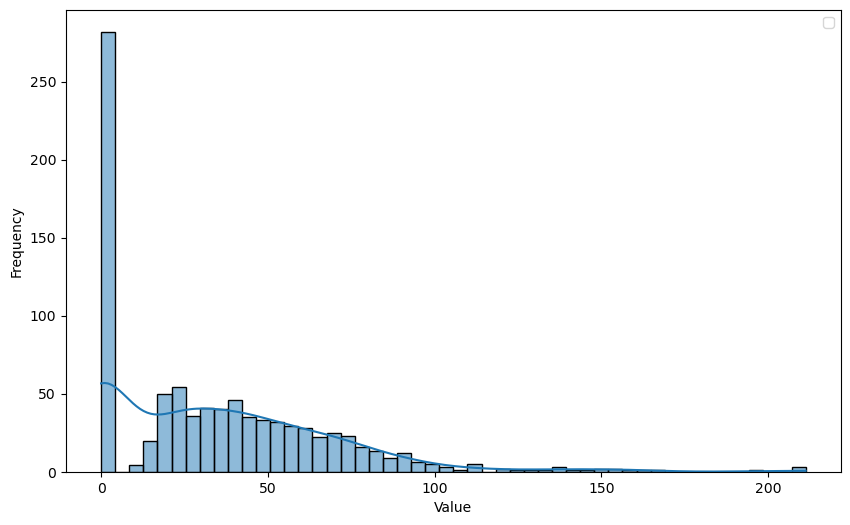

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

data = valid_id_scores.T

# Plot the distribution and KDE for each column in the dataset
plt.figure(figsize=(10, 6))

sns.histplot(data[6,:], bins=50, kde=True, alpha=0.5)
# sns.histplot(data[1,:], bins=50, kde=True, alpha=0.5)
# sns.kdeplot(data[0,:], label=names[0], alpha=0.5)
# sns.kdeplot(data[1,:], label=names[1], alpha=0.5)
# sns.kdeplot(data[2,:], label=names[2], alpha=0.5)

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# plt.xlim(-0.5, 30)

# Show plot
plt.show()


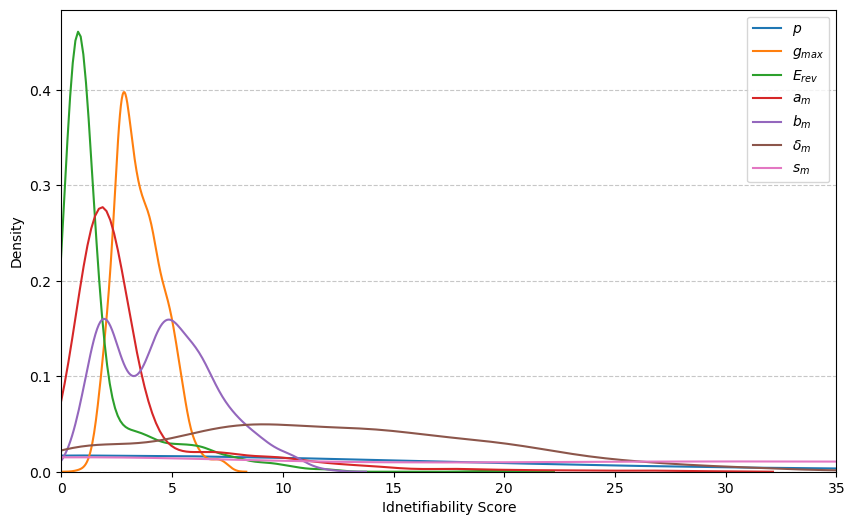

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
j = 0
for i, data in enumerate(valid_id_scores.T, start=1):
    sns.kdeplot(data, label=names[j], linewidth=1.5)
    j += 1
plt.xlabel('Idnetifiability Score')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlim(0, 35)
plt.show()

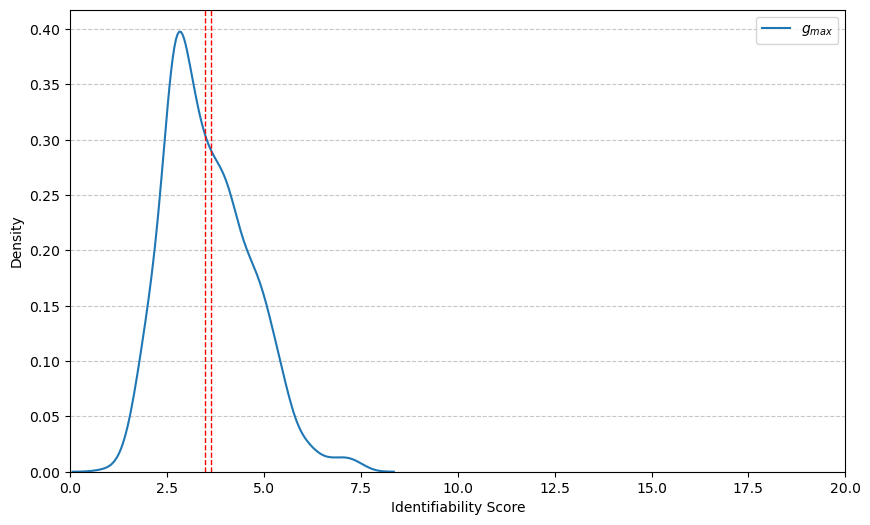

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


# Plotting
plt.figure(figsize=(10, 6))
# for data, name in zip(valid_id_scores.T, names):
#     sns.kdeplot(data, label=name, linewidth=1.5)

#     # Calculate 95% confidence interval
#     mean, std_dev = np.mean(data), np.std(data, ddof=1)
#     conf_interval = norm.interval(0.95, loc=mean, scale=std_dev/np.sqrt(len(data)))

#     # Overlay confidence interval on the plot
#     plt.axvline(conf_interval[0], color='red', linestyle='--', linewidth=1)
#     plt.axvline(conf_interval[1], color='red', linestyle='--', linewidth=1)

data = (valid_id_scores.T)[1]
sns.kdeplot(data, label=names[1], linewidth=1.5)

# Calculate 95% confidence interval
mean, std_dev = np.mean(data), np.std(data, ddof=1)
conf_interval = norm.interval(0.95, loc=mean, scale=std_dev/np.sqrt(len(data)))

# Overlay confidence interval on the plot
plt.axvline(conf_interval[0], color='red', linestyle='--', linewidth=1)
plt.axvline(conf_interval[1], color='red', linestyle='--', linewidth=1)

plt.xlabel('Identifiability Score')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlim(0, 20)  # Adjust x-axis limits as needed
plt.show()


In [74]:
identifiability_score[32]

array([7.50388062e-05, 2.97987604e+00, 2.05693150e+00, 1.19052668e+01,
       3.57572293e+00, 3.57530937e+01, 1.55914154e+02])

In [75]:
identifiability_score[9]

array([4.34591566e-05, 3.91357350e+00, 7.92065322e-01, 2.29236507e+00,
       6.23647022e+00, 9.43502712e+00, 4.87354774e+01])

In [177]:
dataset.params[32], dataset.params[9]

(tensor([  4.0000, 117.6200, -91.7515,   3.0628,   2.1279,   0.9771, -10.9048]),
 tensor([  4.0000, 118.2752, -71.8171,   2.0534,  13.0613,   0.1571, -11.0760]))